In [1]:
import os
from sklearn.model_selection import train_test_split

def prepare_data(data_dir, train_file_path="train_data.txt", test_file_path="test_data.txt", test_size=0.2, random_state=42):
    images_dir = os.path.join(data_dir, "image_tiles_/")
    masks_dir = os.path.join(data_dir, "mask_tiles_/")

    # List all image and mask files
    image_files = sorted(os.listdir(images_dir))  # All image filenames
    mask_files = sorted(os.listdir(masks_dir))    # All mask filenames

    # Create a dictionary to map image filenames to corresponding mask filenames
    image_mask_mapping = {}

    # Assuming filenames have some common pattern (e.g., image_001.png, mask_001_1.png)
    for image_file in image_files:
        # Extract image ID
        image_id = os.path.splitext(image_file)[0]
        corresponding_masks = [mask for mask in mask_files if image_id in mask]

        # Store the image and its corresponding masks
        image_mask_mapping[image_file] = corresponding_masks

    # Create the list of all image-mask pairs
    all_pairs = []
    for image_file, mask_list in image_mask_mapping.items():
        for mask_file in mask_list:
            image_path = os.path.join(images_dir, image_file)
            mask_path = os.path.join(masks_dir, mask_file)
            all_pairs.append({"image": image_path, "annotation": mask_path})

    print(f"Total data size: {len(all_pairs)}")

    # Split the data into train and test sets
    train_pairs, test_pairs = train_test_split(all_pairs, test_size=test_size, random_state=random_state)

    # Save training data to 'train_data.txt'
    with open(train_file_path, "a") as train_file:
        for pair in train_pairs:
            train_file.write(f"'image_path':{pair['image']},'annotation_path': {pair['annotation']}\n")

    # Save testing data to 'test_data.txt'
    with open(test_file_path, "a") as test_file:
        for pair in test_pairs:
            test_file.write(f"'image_path':{pair['image']}, 'annotation_path':{pair['annotation']}\n")

    # Optionally, print the sizes and some examples for verification
    print(f"Training data size: {len(train_pairs)}")
    print(f"Testing data size: {len(test_pairs)}")

    return train_pairs,test_pairs
data_directory = "/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/ct_waterbury_city/output/step6_outputs/"
train_pairs,test_pairs = prepare_data(data_directory)
print("first element of the train_pairs",train_pairs[0])

Total data size: 519
Training data size: 415
Testing data size: 104
first element of the train_pairs {'image': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/ct_waterbury_city/output/step6_outputs/image_tiles_/87_waterbury_224.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/ct_waterbury_city/output/step6_outputs/mask_tiles_/87_waterbury_224.jpg'}


In [2]:
from shapely.geometry import Polygon
import cv2
from shapely.validation import make_valid
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
# After
def get_representative_points_within_contours(contours, contours_1):
    """Get representative points within each part of the polygon or a reduced number if there's intersection with contours_1."""
    representative_points = []

    def get_quadrant_representative_points(polygon):
        """Get representative points from the quadrants of a polygon."""
        min_x, min_y, max_x, max_y = polygon.bounds
        center_x = (min_x + max_x) / 2
        center_y = (min_y + max_y) / 2

        quadrants = [
            Polygon([(min_x, min_y), (center_x, min_y), (center_x, center_y), (min_x, center_y)]),
            Polygon([(center_x, min_y), (max_x, min_y), (max_x, center_y), (center_x, center_y)]),
            Polygon([(min_x, center_y), (center_x, center_y), (center_x, max_y), (min_x, max_y)]),
            Polygon([(center_x, center_y), (max_x, center_y), (max_x, max_y), (center_x, max_y)])
        ]

        temp_points = []  # Temporary list to hold quadrant representative points

        for quadrant in quadrants:
            if quadrant.intersects(polygon):
                intersection = quadrant.intersection(polygon)
                if not intersection.is_empty:
                    rep_point = intersection.representative_point()
                    temp_points.append((rep_point.x, rep_point.y))

        return temp_points

    for contour_1 in contours_1:
        try:
            shapely_polygon = Polygon([(point[0][0], point[0][1]) for point in contour_1])
            shapely_polygon = make_valid(shapely_polygon)  # Ensure the polygon is valid
            count = 0
            tmp_pts = []

            for contour in contours:
                # shapely_polygon_1 = Polygon([(point[0][0], point[0][1]) for point in contour])
                coordinates = []
                for point in contour:
                    x = point[0][0]
                    y = point[0][1]
                    coordinates.append((x, y))

                if len(coordinates)>3:
                # Create the polygon using the list of coordinates
                    shapely_polygon_1 = Polygon(coordinates)
                    shapely_polygon_1 = make_valid(shapely_polygon_1)  # Ensure the polygon is valid
                 

                    if shapely_polygon.intersects(shapely_polygon_1):
                        count += 1

                        if shapely_polygon_1.area <= 200:
                            rep_point = shapely_polygon_1.representative_point()
                            representative_points.append(([(rep_point.x, rep_point.y)]))
                            print("representative point after area is less than 200",representative_points)
                        else:
                            tmp_pts.append(get_quadrant_representative_points(shapely_polygon_1))

            if count > 1:
                print("length of tmp_pts",len(tmp_pts))
                if len(tmp_pts) >= 2:
                    representative_points.append(list(random.sample(tmp_pts[0], 2)))
                    representative_points.append(list(random.sample(tmp_pts[1], 2)))
                elif tmp_pts:
                    representative_points.extend(list(tmp_pts[0]))
            elif count==1:
#                 rep_point = shapely_polygon.representative_point()
#                 representative_points.append((rep_point.x, rep_point.y))  # To tackle the case where intersection is not present
                if tmp_pts:
                # If no multiple intersections, still get quadrant points
                    
                    representative_points.append(list(tmp_pts[0]))
#                     print(representative_points)
            else:
                rep_point = shapely_polygon.representative_point()
                representative_points.append([((rep_point.x, rep_point.y))])  # 

                # if tmp_pts:
                    
                # # If no multiple intersections, still get quadrant points
                #     representative_points.extend(tmp_pts[0])


        except ValueError as e:
            print(f"Error creating polygon: {e}")
            continue

    return representative_points

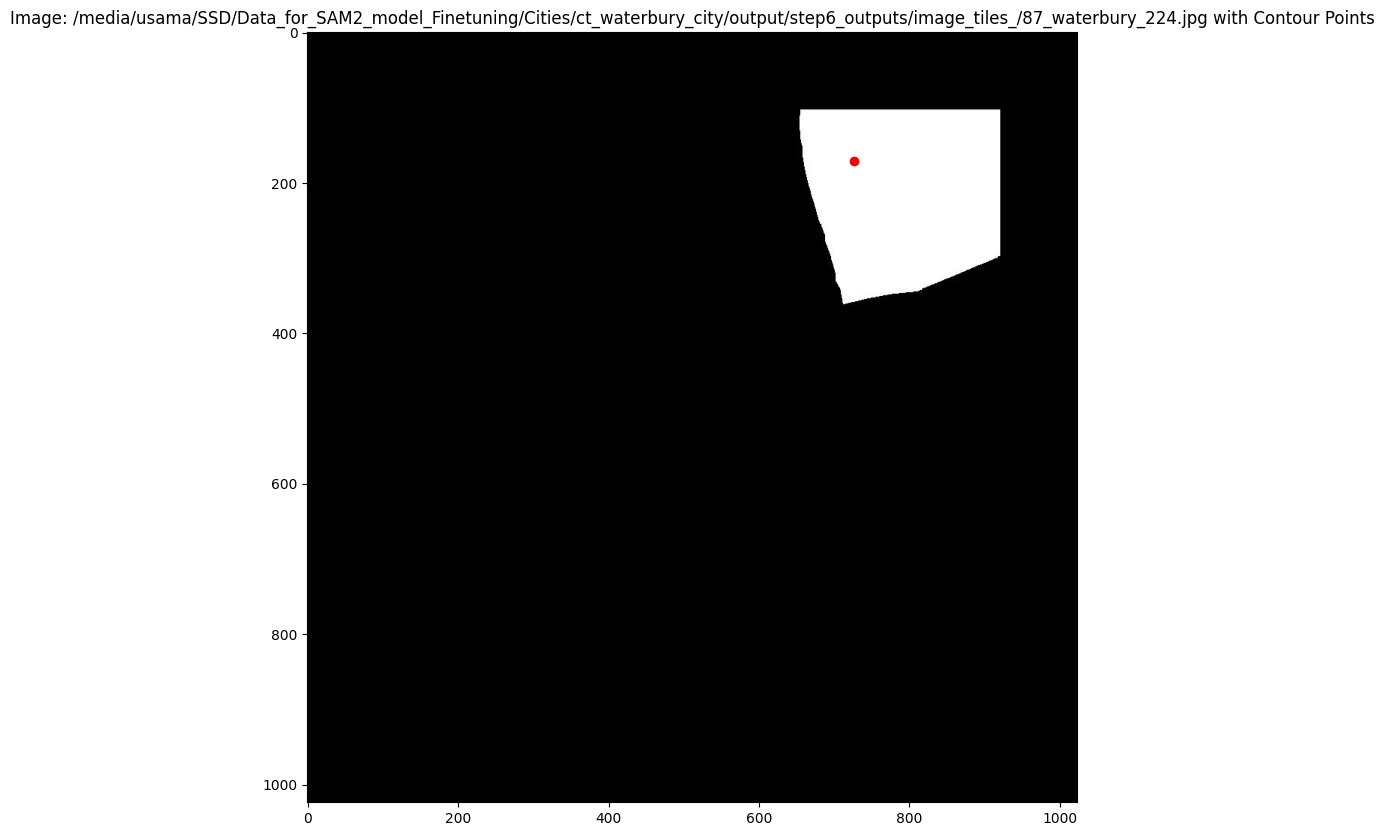

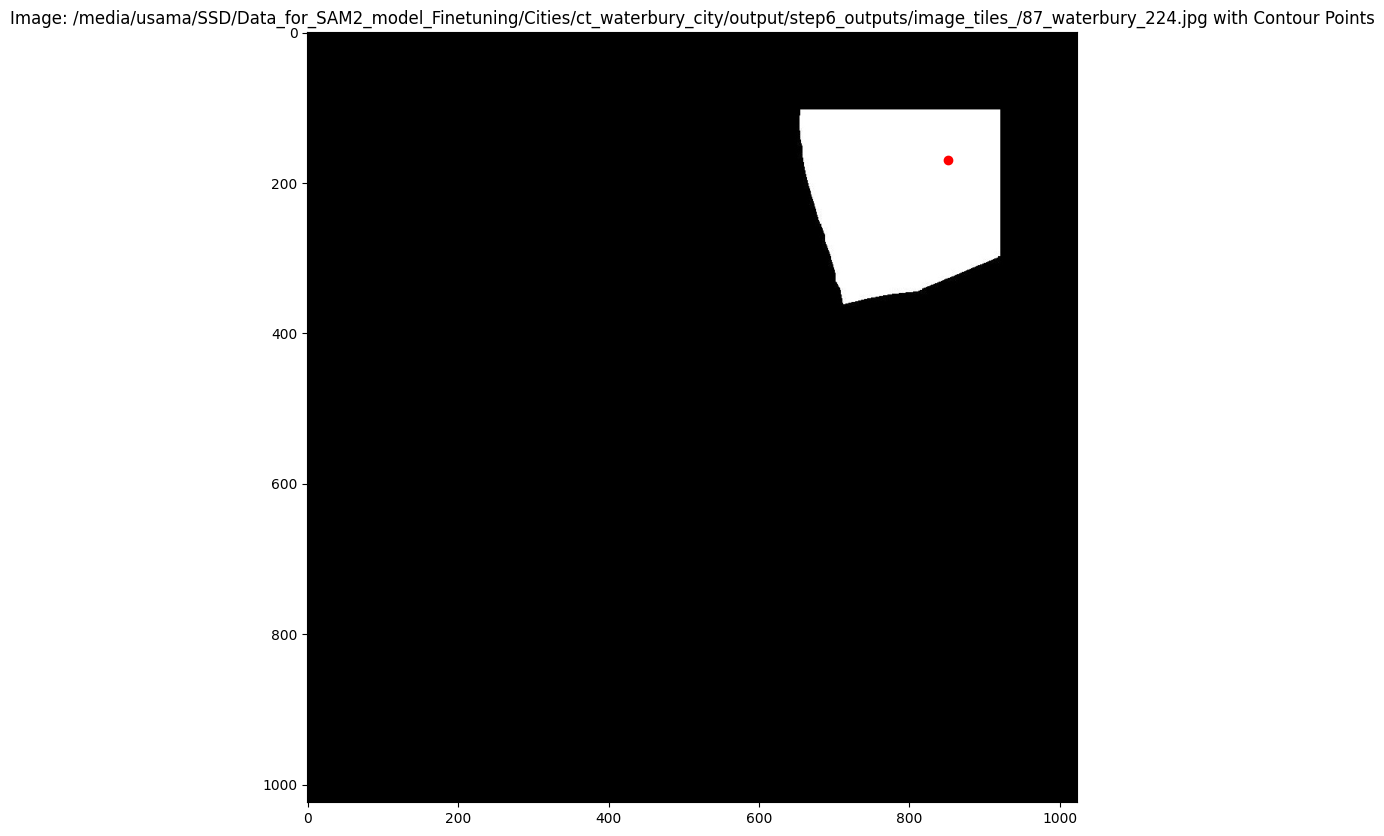

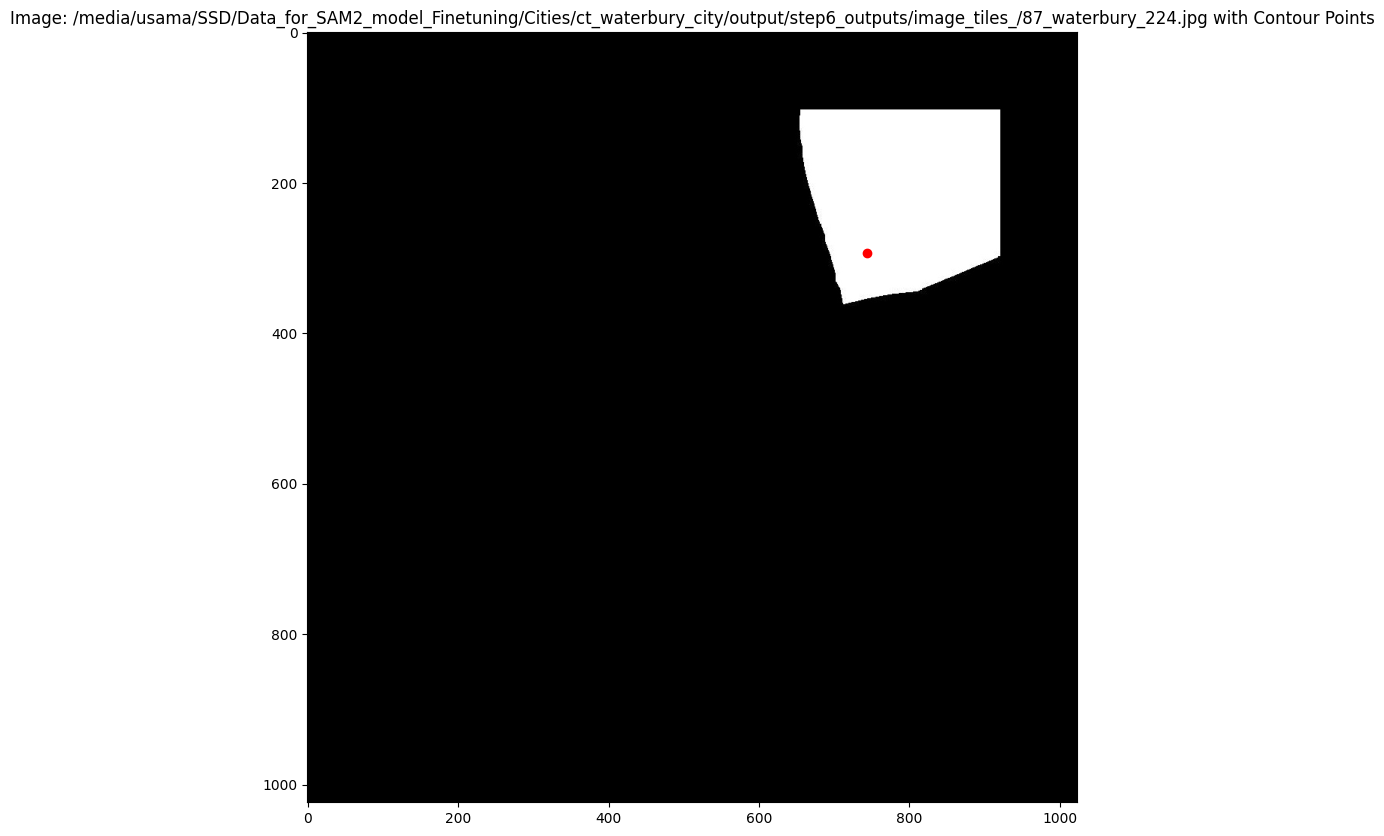

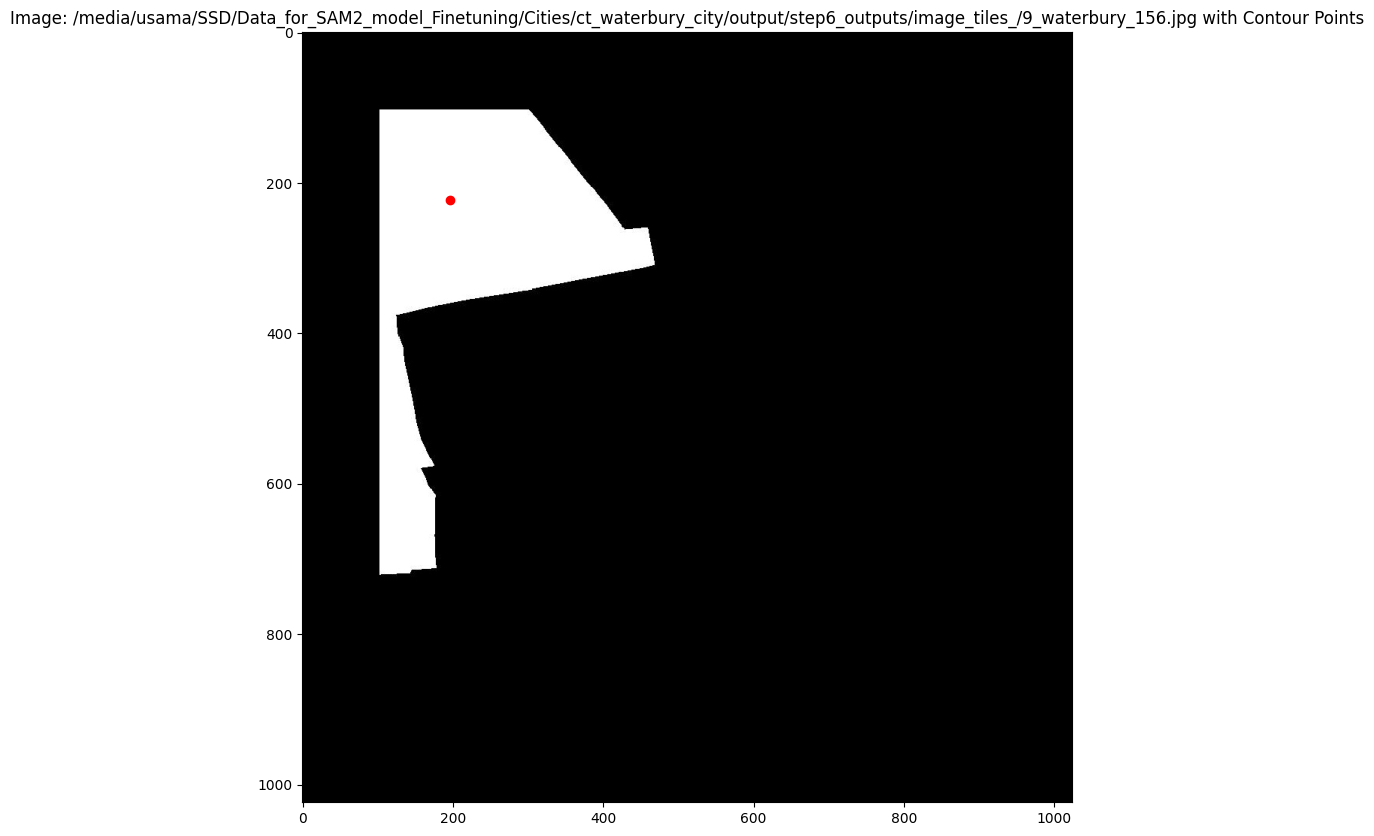

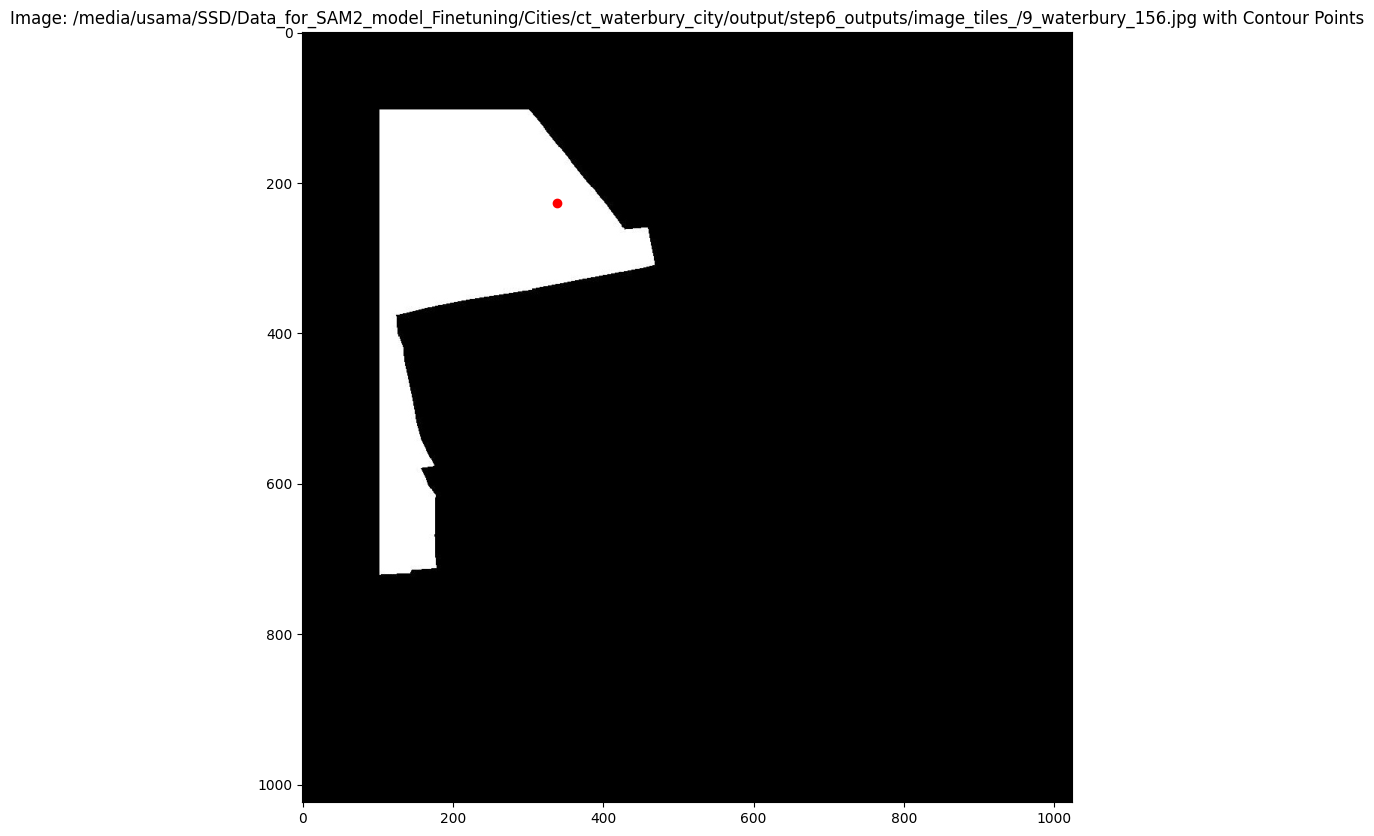

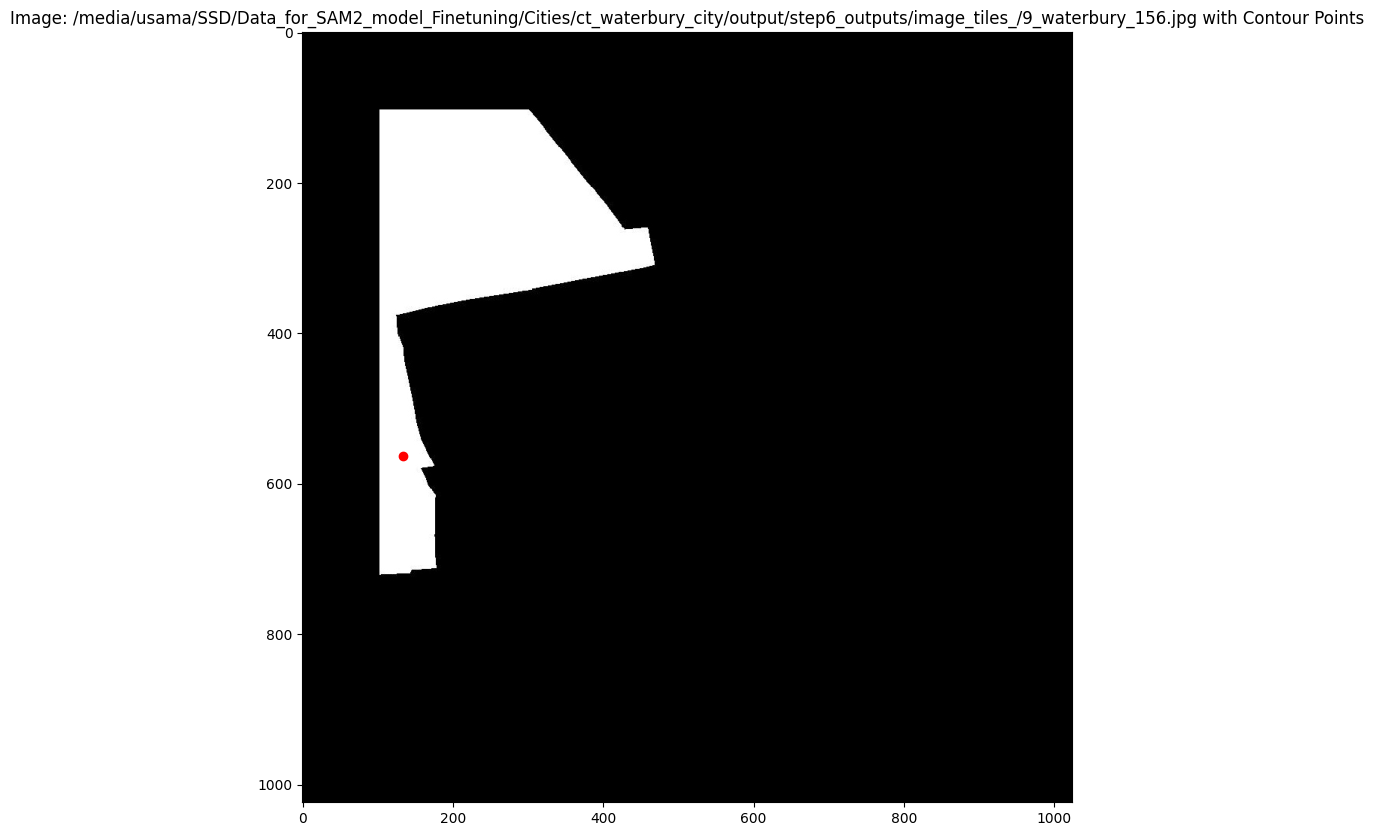

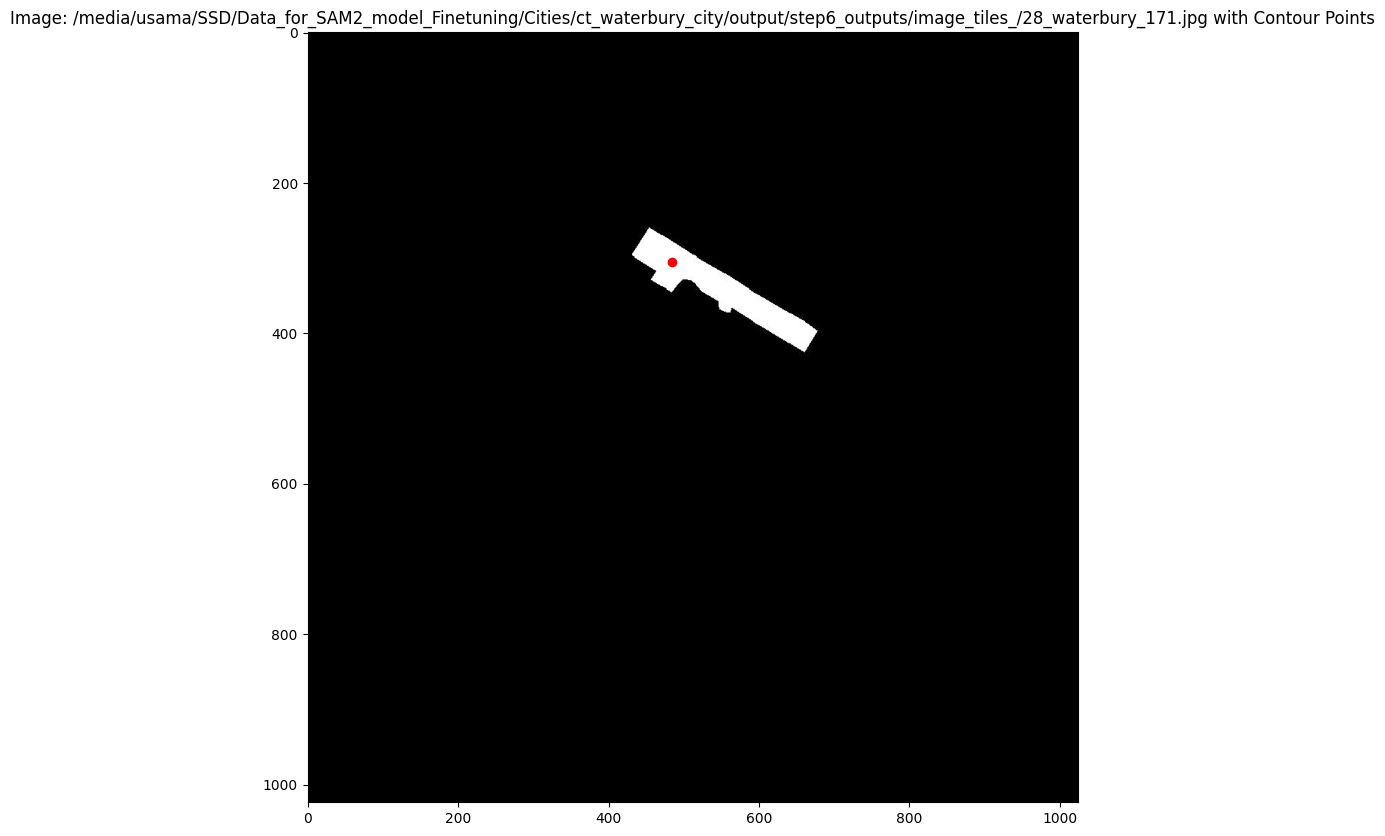

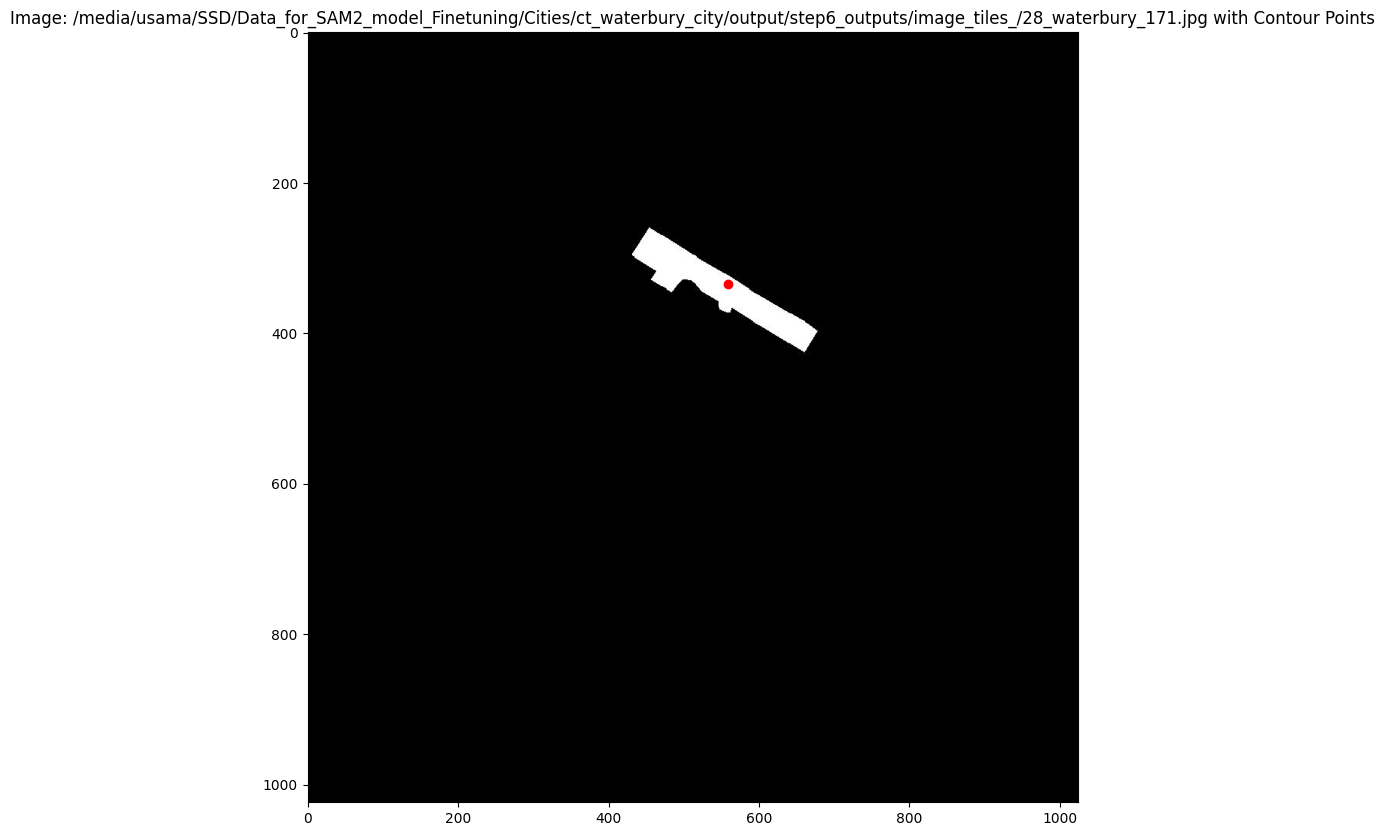

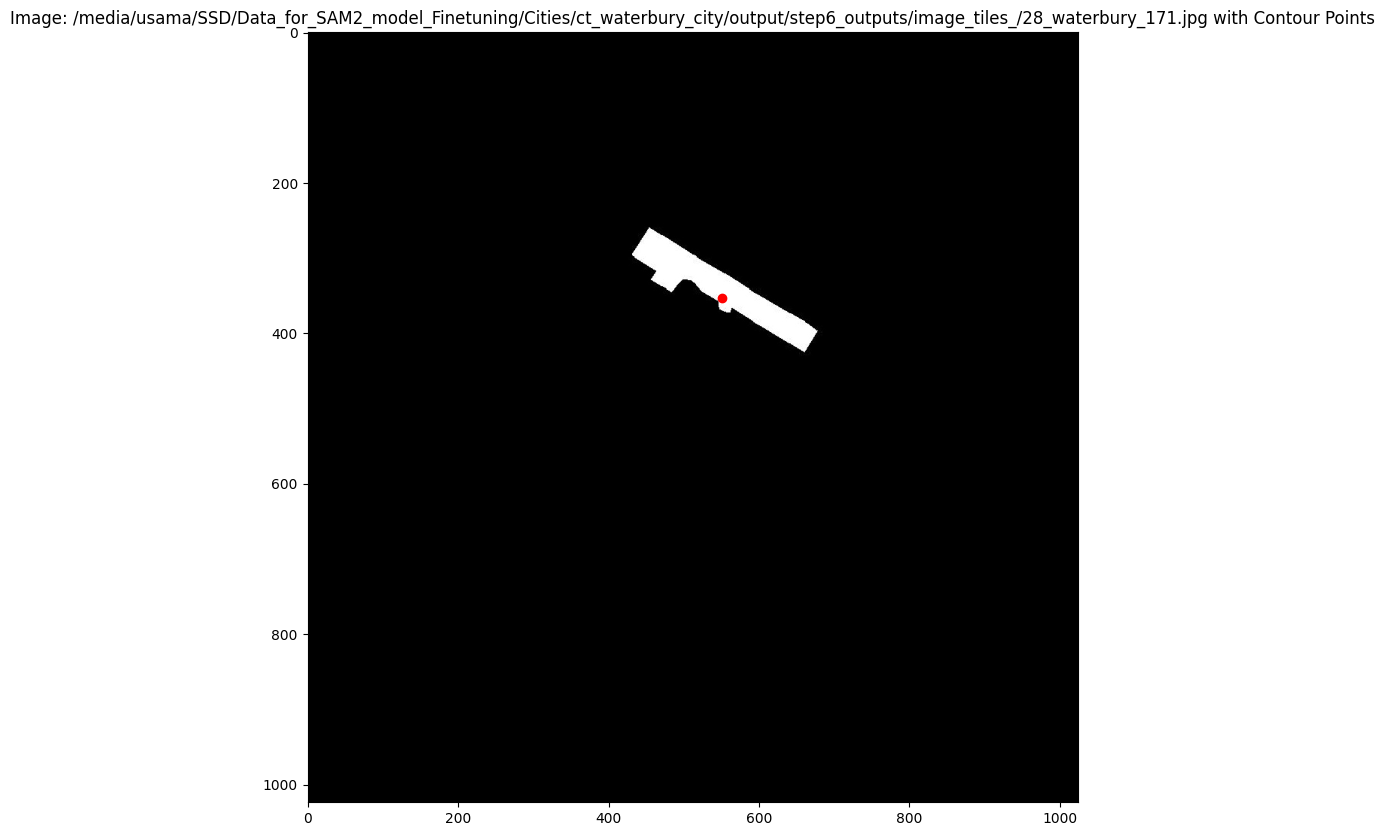

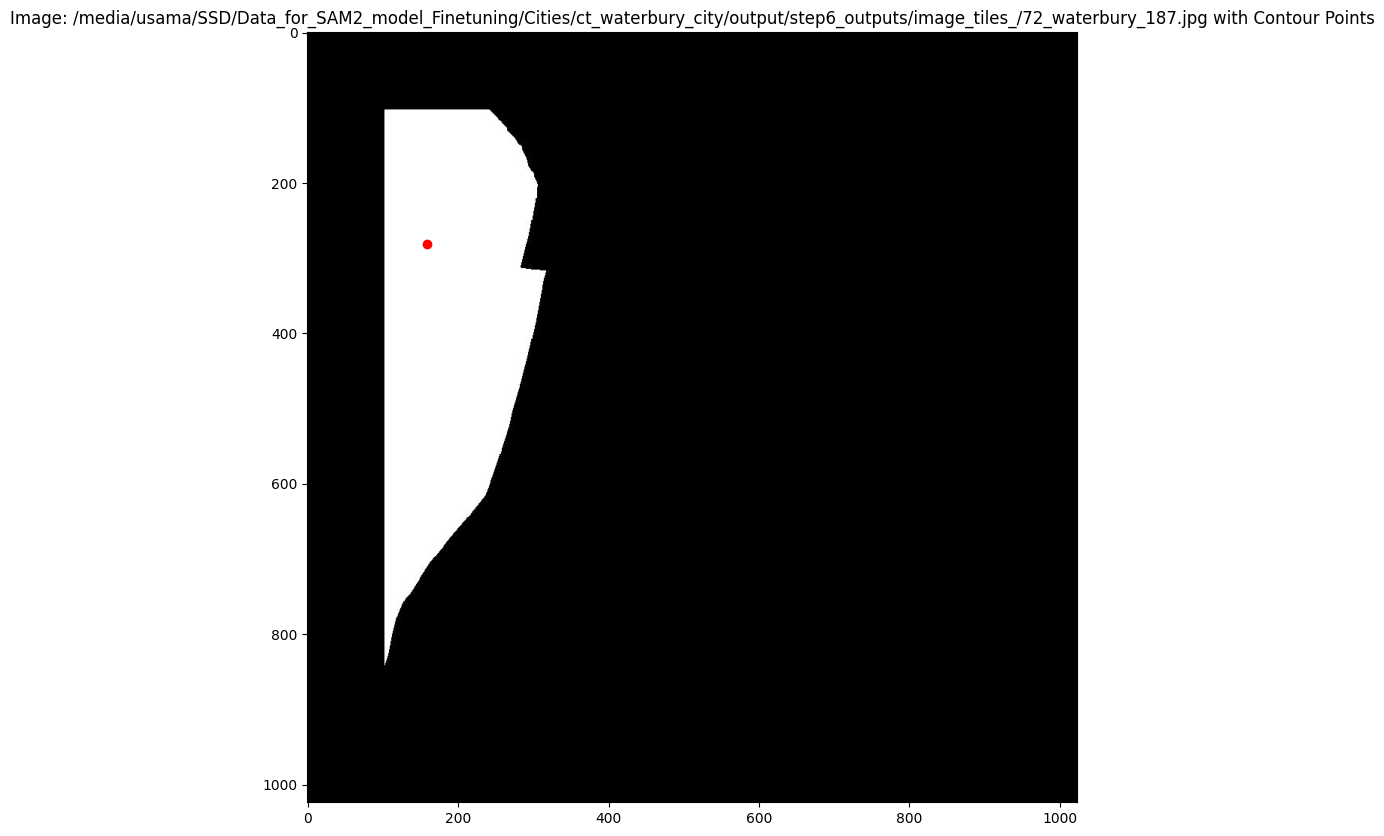

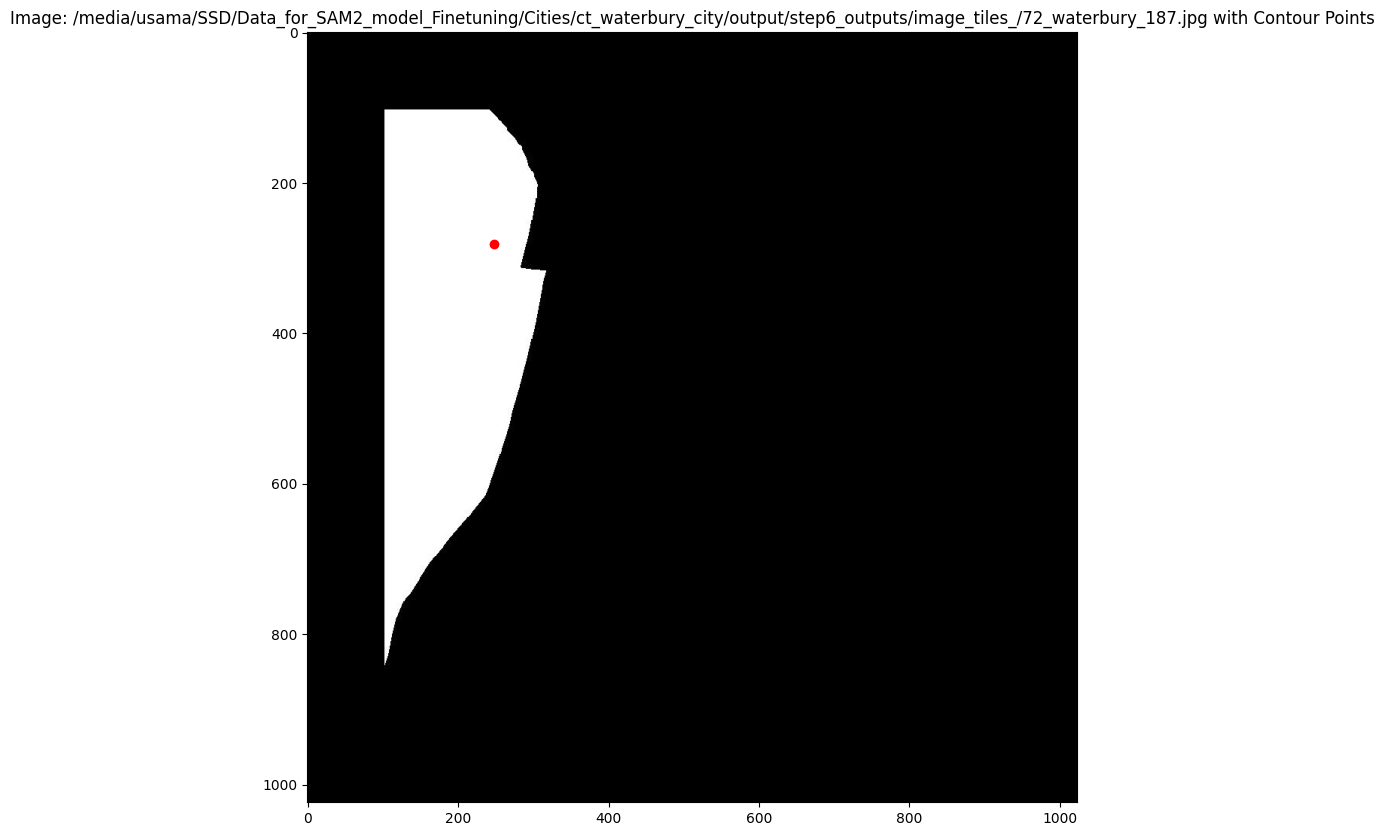

In [ ]:
# After
def read_batch(data, visualize_data=False):
    results = []

    for ent in data:
        image = cv2.imread(ent["image"])[..., ::-1]
        ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)

        if image is None or ann_map is None:
            print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
            continue

        scale = min(1024 / image.shape[1], 1024 / image.shape[0])
        image = cv2.resize(image, (int(image.shape[1] * scale), int(image.shape[0] * scale)))
        ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * scale), int(ann_map.shape[0] * scale)), interpolation=cv2.INTER_NEAREST)

        _, binary_mask = cv2.threshold(ann_map, 127, 255, cv2.THRESH_BINARY)
        contours_1, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_1_blank_image = np.zeros(image.shape[:2],dtype=np.uint8)
#         print("Contours length before erosion:", len(contours_1))
        eroded_mask = cv2.erode(ann_map, np.ones((5, 5), np.uint8), iterations=2)
        _, binary_mask_eroded = cv2.threshold(eroded_mask, 127, 255, cv2.THRESH_BINARY)
        contours_2, _ = cv2.findContours(binary_mask_eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_2_blank_image = np.zeros(image.shape[:2],dtype=np.uint8)
#         print("Contours length after erosion:", len(contours_2))
        final_mask = cv2.erode(ann_map, np.ones((5, 5), np.uint8), iterations=2) if len(contours_2) >= len(contours_1) else ann_map
        for i in range(1, 2):
            txt_file_path = 'contour_points.txt'
            _, binary_mask_final = cv2.threshold(final_mask, 100, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(binary_mask_final, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Get representative points with intersection logic
            points = get_representative_points_within_contours(contours, contours_1)
#             print("length of points",len(points))
#             print("points",points)
            count = 0
            for item in points:
                if len(item)>=3:
                    count+=1
            if count==len(points):
                points = points
            else:
                continue
            for i in range(3):
                points_pair = []
                for element in points:
                    # Get the i-th point from each element and convert to integer
                    point = tuple(map(int, element[i]))  # Convert to integer
                    points_pair.append(point)
                    with open(txt_file_path, 'a') as file:
                        # for point in points:
                        for (cX, cY) in points_pair:
                            file.write(f'{cX}, {cY}\n')
                if visualize_data:
                    plt.figure(figsize=(10, 10))
                    plt.imshow(ann_map, cmap='gray')
                    for (cX, cY) in points_pair:
                        plt.plot(cX, cY, 'ro')
                    plt.title(f"Image: {ent['image']} with Contour Points")
                    plt.show()
                
                
                results.append({
                "image": ent["image"],
                "annotation": ent["annotation"],
                "txt_file": txt_file_path,
                "points": points_pair

        })


    return results

# train_data =   [{'image': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/ct_waterbury_city/output/step6_outputs/image_tiles_/0_waterbury_43.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/ct_waterbury_city/output/step6_outputs/mask_tiles_/0_waterbury_43.jpg'}]
# train_data =   [{'image': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/ct_waterbury_city/output/step6_outputs/image_tiles_/99_waterbury_153.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/ct_waterbury_city/output/step6_outputs/mask_tiles_/99_waterbury_153.jpg'}]
results = read_batch(train_pairs, visualize_data=True)
# results = read_batch(train_data, visualize_data=True)
print("Length of results:", len(results))
# print(results)

In [ ]:
image_path = results[2]["image"]
print("image path",image_path)
annotation_path = results[2]["annotation"]
print("annotation path",annotation_path)
points=results[2]["points"]
print("point",points)

In [ ]:
print(results[0])

In [ ]:
# Before
# def get_representative_points_within_contours(contours, contours_1):
#     """Get representative points within each part of the polygon or a reduced number if there's intersection with contours_1."""
#     representative_points = []

#     def get_quadrant_representative_points(polygon):
#         """Get representative points from the quadrants of a polygon."""
#         min_x, min_y, max_x, max_y = polygon.bounds
#         center_x = (min_x + max_x) / 2
#         center_y = (min_y + max_y) / 2

#         quadrants = [
#             Polygon([(min_x, min_y), (center_x, min_y), (center_x, center_y), (min_x, center_y)]),
#             Polygon([(center_x, min_y), (max_x, min_y), (max_x, center_y), (center_x, center_y)]),
#             Polygon([(min_x, center_y), (center_x, center_y), (center_x, max_y), (min_x, max_y)]),
#             Polygon([(center_x, center_y), (max_x, center_y), (max_x, max_y), (center_x, max_y)])
#         ]

#         temp_points = []  # Temporary list to hold quadrant representative points

#         for quadrant in quadrants:
#             if quadrant.intersects(polygon):
#                 intersection = quadrant.intersection(polygon)
#                 if not intersection.is_empty:
#                     rep_point = intersection.representative_point()
#                     temp_points.append((rep_point.x, rep_point.y))

#         return temp_points

#     for contour_1 in contours_1:
#         try:
#             shapely_polygon = Polygon([(point[0][0], point[0][1]) for point in contour_1])
#             shapely_polygon = make_valid(shapely_polygon)  # Ensure the polygon is valid
#             count = 0
#             tmp_pts = []

#             for contour in contours:
#                 # shapely_polygon_1 = Polygon([(point[0][0], point[0][1]) for point in contour])
#                 coordinates = []
#                 for point in contour:
#                     x = point[0][0]
#                     y = point[0][1]
#                     coordinates.append((x, y))

#                 if len(coordinates)>3:
#                 # Create the polygon using the list of coordinates
#                     shapely_polygon_1 = Polygon(coordinates)
#                     shapely_polygon_1 = make_valid(shapely_polygon_1)  # Ensure the polygon is valid

#                     if shapely_polygon.intersects(shapely_polygon_1):
#                         count += 1

#                         if shapely_polygon_1.area <= 200:
#                             rep_point = shapely_polygon_1.representative_point()
#                             representative_points.append((rep_point.x, rep_point.y))
#                         else:
#                            tmp_pts.append(get_quadrant_representative_points(shapely_polygon_1))

#             if count > 1:
#                 if len(tmp_pts) >= 2:
#                     representative_points.extend(random.sample(tmp_pts[0], 2))
#                     representative_points.extend(random.sample(tmp_pts[1], 2))
#                 elif tmp_pts:
            
#                     representative_points.extend(tmp_pts[0])
#             elif count==1:
# #                 rep_point = shapely_polygon.representative_point()
# #                 representative_points.append((rep_point.x, rep_point.y))  # To tackle the case where intersection is not present
#                 if tmp_pts:
#                 # If no multiple intersections, still get quadrant points
                    
#                     representative_points.extend(tmp_pts[0])
#             else:
#                 rep_point = shapely_polygon.representative_point()
#                 representative_points.append((rep_point.x, rep_point.y))  # 
                


#         except ValueError as e:
#             print(f"Error creating polygon: {e}")
#             continue

#     return representative_points

In [ ]:
# def read_batch(data, visualize_data=False):
#     results = []

#     for ent in data:
#         image = cv2.imread(ent["image"])[..., ::-1]
#         ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)

#         if image is None or ann_map is None:
#             print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
#             continue

#         scale = min(1024 / image.shape[1], 1024 / image.shape[0])
#         image = cv2.resize(image, (int(image.shape[1] * scale), int(image.shape[0] * scale)))
#         ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * scale), int(ann_map.shape[0] * scale)), interpolation=cv2.INTER_NEAREST)

#         _, binary_mask = cv2.threshold(ann_map, 127, 255, cv2.THRESH_BINARY)
#         contours_1, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         print("Contours length before erosion:", len(contours_1))

#         eroded_mask = cv2.erode(ann_map, np.ones((5, 5), np.uint8), iterations=2)
#         _, binary_mask_eroded = cv2.threshold(eroded_mask, 127, 255, cv2.THRESH_BINARY)
#         contours_2, _ = cv2.findContours(binary_mask_eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         print("Contours length after erosion:", len(contours_2))

#         final_mask = cv2.erode(ann_map, np.ones((5, 5), np.uint8), iterations=2) if len(contours_2) >= len(contours_1) else ann_map
#         for i in range(1, 3):
#             txt_file_path = 'contour_points.txt'
#             _, binary_mask_final = cv2.threshold(final_mask, 100, 255, cv2.THRESH_BINARY)
#             contours, _ = cv2.findContours(binary_mask_final, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#             # Get representative points with intersection logic
#             points = get_representative_points_within_contours(contours, contours_1)
#             print("length of points",len(points))
#             print(points)

#             # Write points to text file
#             with open(txt_file_path, 'a') as file:
#                 for (cX, cY) in points:
#                     file.write(f'{cX}, {cY}\n')

#             results.append({
#                 "image": ent["image"],
#                 "annotation": ent["annotation"],
#                 "txt_file": txt_file_path,
#                 "points": points
#             })

#             if visualize_data:
#                 plt.figure(figsize=(10, 10))
#                 plt.imshow(ann_map, cmap='gray')
#                 for (cX, cY) in points:
#                     plt.plot(cX, cY, 'ro')
#                 plt.title(f"Image: {ent['image']} with Contour Points")
#                 plt.show()

#     return results

# # train_data = [{'image': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/notebook/data/image_tiles/19_4326_41.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/notebook/data/mask_tiles/19_4326_41.jpg'}]
# # train_data =   [{'image': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/notebook/data/image_tiles/4_4326_50.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/notebook/data/mask_tiles/4_4326_50.jpg'}]
# # train_data =   [{'image': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/brisbane_old_city/output/image_tiles_and_mask_tiles_for_bresbane_old_city_latest/image_tiles_29_oct_2024_11/19_4326_51.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/brisbane_old_city/output/image_tiles_and_mask_tiles_for_bresbane_old_city_latest/mask_tiles_29_oct_2024_11/19_4326_51.jpg'}]
# # train_data =   [{'image': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/brisbane_old_city/output/image_tiles_and_mask_tiles_for_bresbane_old_city_latest/image_tiles_29_oct_2024_11/16_4326_52.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/brisbane_old_city/output/image_tiles_and_mask_tiles_for_bresbane_old_city_latest/mask_tiles_29_oct_2024_11/16_4326_52.jpg'}]
# # train_data =   [{'image': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/ct_waterbury_city/output/step6_outputs/image_tiles_/41_waterbury_203.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/ct_waterbury_city/output/step6_outputs/mask_tiles_/41_waterbury_203.jpg'}]
# train_data =   [{'image': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/ct_waterbury_city/output/step6_outputs/image_tiles_/0_waterbury_43.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/ct_waterbury_city/output/step6_outputs/mask_tiles_/0_waterbury_43.jpg'}]
# results = read_batch(train_pairs, visualize_data=True)
# print("Length of results:", len(results))

In [ ]:
image_path = results[2]["image"]
print("image path",image_path)
annotation_path = results[2]["annotation"]
print("annotation path",annotation_path)
points=results[2]["points"]
print("point",points)



# image path /media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/ct_waterbury_city/output/step6_outputs/image_tiles_/0_waterbury_43.jpg
# annotation path /media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/ct_waterbury_city/output/step6_outputs/mask_tiles_/0_waterbury_43.jpg
# point [(775, 243), (183, 253)]




In [ ]:
# for point in points:
#     print(point)
cX,cY = (183,759)
ann_map = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)
scale = min(1024 / ann_map.shape[1], 1024 / ann_map.shape[0])

ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * scale), int(ann_map.shape[0] * scale)), interpolation=cv2.INTER_NEAREST)


plt.figure(figsize=(10, 10))
# plt.imshow(image)
plt.imshow(ann_map, cmap='gray')
# plt.imshow(ann_map_copy, cmap='gray', alpha=0.3)  # Overlay annotation map with transparency
#     for (cX, cY) in point:
plt.plot(cX, cY, 'ro')  # Plot each random point in red
plt.title(f"Image: with Contour Points")
plt.show()


In [ ]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# Before

# def read_batch(data, visualize_data=False):
#     results = []
    
#     for ent in data:
#         image = cv2.imread(ent["image"])[..., ::-1]
#         ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)

#         if image is None or ann_map is None:
#             print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
#             continue

#         # Resizing to 1024x1024 or keeping aspect ratio
#         scale = min(1024 / image.shape[1], 1024 / image.shape[0])
#         image = cv2.resize(image, (int(image.shape[1] * scale), int(image.shape[0] * scale)))
#         ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * scale), int(ann_map.shape[0] * scale)), interpolation=cv2.INTER_NEAREST)

#         # Binary mask for finding contours
#         _, binary_mask = cv2.threshold(ann_map, 127, 255, cv2.THRESH_BINARY)
#         contours_1, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
#         # Erosion operation on annotation map
#         eroded_mask = cv2.erode(ann_map, np.ones((5, 5), np.uint8), iterations=2)
#         _, binary_mask_eroded = cv2.threshold(eroded_mask, 127, 255, cv2.THRESH_BINARY)
        
#         contours_2, _ = cv2.findContours(binary_mask_eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
#         # Final mask based on contour comparison
#         final_mask = cv2.erode(ann_map, np.ones((5, 5), np.uint8), iterations=2) if len(contours_2) >= len(contours_1) else ann_map
        
#         # Threshold and find contours on final mask
#         _, binary_mask_final = cv2.threshold(final_mask, 100, 255, cv2.THRESH_BINARY)
#         contours, _ = cv2.findContours(binary_mask_final, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#         # Obtain representative points with intersection logic
#         points = get_representative_points_within_contours(contours, contours_1)
        
#         # Write points to text file and visualize if needed
#         txt_file_path = 'contour_points.txt'
#         with open(txt_file_path, 'a') as file:
#             for point in points:
#                 for (cX, cY) in point:
#                     file.write(f'{cX}, {cY}\n')

#         results.append({
#             "image": ent["image"],
#             "annotation": ent["annotation"],
#             "txt_file": txt_file_path,
#             "points": points
#         })

#         # Visualization if requested
#         if visualize_data:
#             plt.figure(figsize=(10, 10))
#             plt.imshow(ann_map, cmap='gray')
#             for point in points:
#                 for (cX, cY) in point:
#                     plt.plot(cX, cY, 'ro')
#             plt.title(f"Image: {ent['image']} with Contour Points")
#             plt.show()

#     return results
# train_data =   [{'image': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/ct_waterbury_city/output/step6_outputs/image_tiles_/0_waterbury_43.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/ct_waterbury_city/output/step6_outputs/mask_tiles_/0_waterbury_43.jpg'}]
# # train_data =   [{'image': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/ct_waterbury_city/output/step6_outputs/image_tiles_/99_waterbury_153.jpg', 'annotation': '/media/usama/SSD/Data_for_SAM2_model_Finetuning/Cities/ct_waterbury_city/output/step6_outputs/mask_tiles_/99_waterbury_153.jpg'}]
# read_batch(train_data, visualize_data=True)



In [ ]:
# for point in points:
#     print(point)
#     cX,cY = point
#     ann_map = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)
#     scale = min(1024 / ann_map.shape[1], 1024 / ann_map.shape[0])

#     ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * scale), int(ann_map.shape[0] * scale)), interpolation=cv2.INTER_NEAREST)


#     plt.figure(figsize=(10, 10))
#     # plt.imshow(image)
#     plt.imshow(ann_map, cmap='gray')
#     # plt.imshow(ann_map_copy, cmap='gray', alpha=0.3)  # Overlay annotation map with transparency
# #     for (cX, cY) in point:
#     plt.plot(cX, cY, 'ro')  # Plot each random point in red
#     plt.title(f"Image: with Contour Points")
#     plt.show()

    

In [ ]:
# def get_representative_points_within_contours(contours, contours_1):
#     """Get representative points within each part of the polygon or a reduced number if there's intersection with contours_1."""
#     representative_points = []

#     def get_quadrant_representative_points(polygon):
#         """Get representative points from the quadrants of a polygon."""
#         min_x, min_y, max_x, max_y = polygon.bounds
#         center_x = (min_x + max_x) / 2
#         center_y = (min_y + max_y) / 2

#         quadrants = [
#             Polygon([(min_x, min_y), (center_x, min_y), (center_x, center_y), (min_x, center_y)]),
#             Polygon([(center_x, min_y), (max_x, min_y), (max_x, center_y), (center_x, center_y)]),
#             Polygon([(min_x, center_y), (center_x, center_y), (center_x, max_y), (min_x, max_y)]),
#             Polygon([(center_x, center_y), (max_x, center_y), (max_x, max_y), (center_x, max_y)])
#         ]

#         temp_points = []  # Temporary list to hold quadrant representative points

#         for quadrant in quadrants:
#             if quadrant.intersects(polygon):
#                 intersection = quadrant.intersection(polygon)
#                 if not intersection.is_empty:
#                     rep_point = intersection.representative_point()
#                     temp_points.append((rep_point.x, rep_point.y))

#         return temp_points

#     for contour_1 in contours_1:
#         try:
#             shapely_polygon = Polygon([(point[0][0], point[0][1]) for point in contour_1])
#             shapely_polygon = make_valid(shapely_polygon)  # Ensure the polygon is valid
#             count = 0
#             tmp_pts = []

#             for contour in contours:
#                 shapely_polygon_1 = Polygon([(point[0][0], point[0][1]) for point in contour])
#                 shapely_polygon_1 = make_valid(shapely_polygon_1)  # Ensure the polygon is valid

#                 if shapely_polygon.intersects(shapely_polygon_1):
#                     count += 1

#                 if shapely_polygon_1.area <= 200:
#                     rep_point = shapely_polygon_1.representative_point()
#                     representative_points.append((rep_point.x, rep_point.y))
#                 else:
#                   tmp_pts.append(get_quadrant_representative_points(shapely_polygon_1))

#             if count > 1:
#                 if len(tmp_pts) > 2:
#                     representative_points.extend(random.sample(tmp_pts[0], 2))
#                     representative_points.extend(random.sample(tmp_pts[1], 2))
#                 else:
#                     representative_points.extend(tmp_pts[0])
#             else:
#                 if tmp_pts:
#                 # If no multiple intersections, still get quadrant points
#                     representative_points.extend(tmp_pts[0])


#         except ValueError as e:
#             print(f"Error creating polygon: {e}")
#             continue

#     return representative_points